<a href="https://colab.research.google.com/github/weagan/Tiny-Recursive-Models/blob/main/Sudoku_TRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
Model params: 163302
Starting training...
Epoch 1/12 | loss 1.6647 | ce 1.6205 | constr 0.0037 | train_cell 0.2709 train_full 0.0000 | val_cell 0.3594 val_full 0.0000 | p_tf 0.400
Epoch 2/12 | loss 1.5945 | ce 1.5851 | constr 0.0008 | train_cell 0.4578 train_full 0.1374 | val_cell 0.5056 val_full 0.0000 | p_tf 0.368
Epoch 3/12 | loss 1.5821 | ce 1.5607 | constr 0.0018 | train_cell 0.5343 train_full 0.4103 | val_cell 0.5044 val_full 0.0000 | p_tf 0.336
Epoch 4/12 | loss 1.5876 | ce 1.5681 | constr 0.0016 | train_cell 0.4213 train_full 0.2692 | val_cell 0.5050 val_full 0.0000 | p_tf 0.305
Epoch 5/12 | loss 1.5924 | ce 1.5752 | constr 0.0014 | train_cell 0.4239 train_full 0.2692 | val_cell 0.5038 val_full 0.0000 | p_tf 0.273
Epoch 6/12 | loss 1.5951 | ce 1.5817 | constr 0.0011 | train_cell 0.3276 train_full 0.1538 | val_cell 0.5036 val_full 0.0000 | p_tf 0.241
Epoch 7/12 | loss 1.6005 | ce 1.5905 | constr 0.0008 | train_cell 0.3561 train_full 0.1923 | val_cell 0.5050 val_full

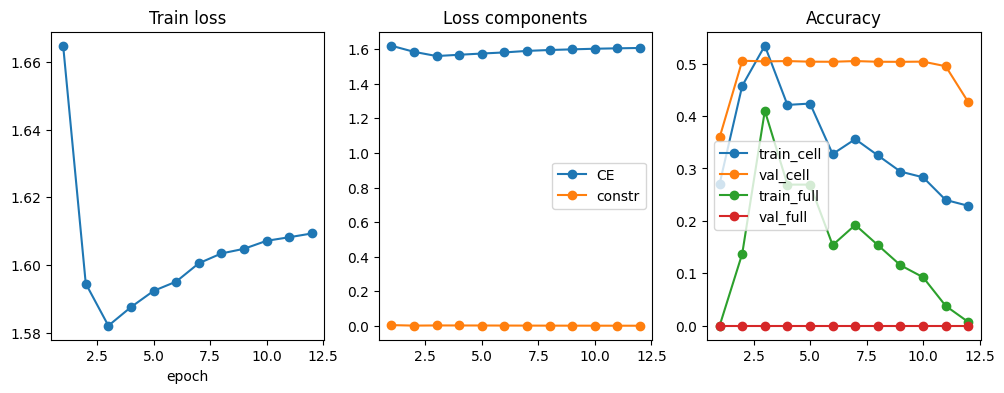

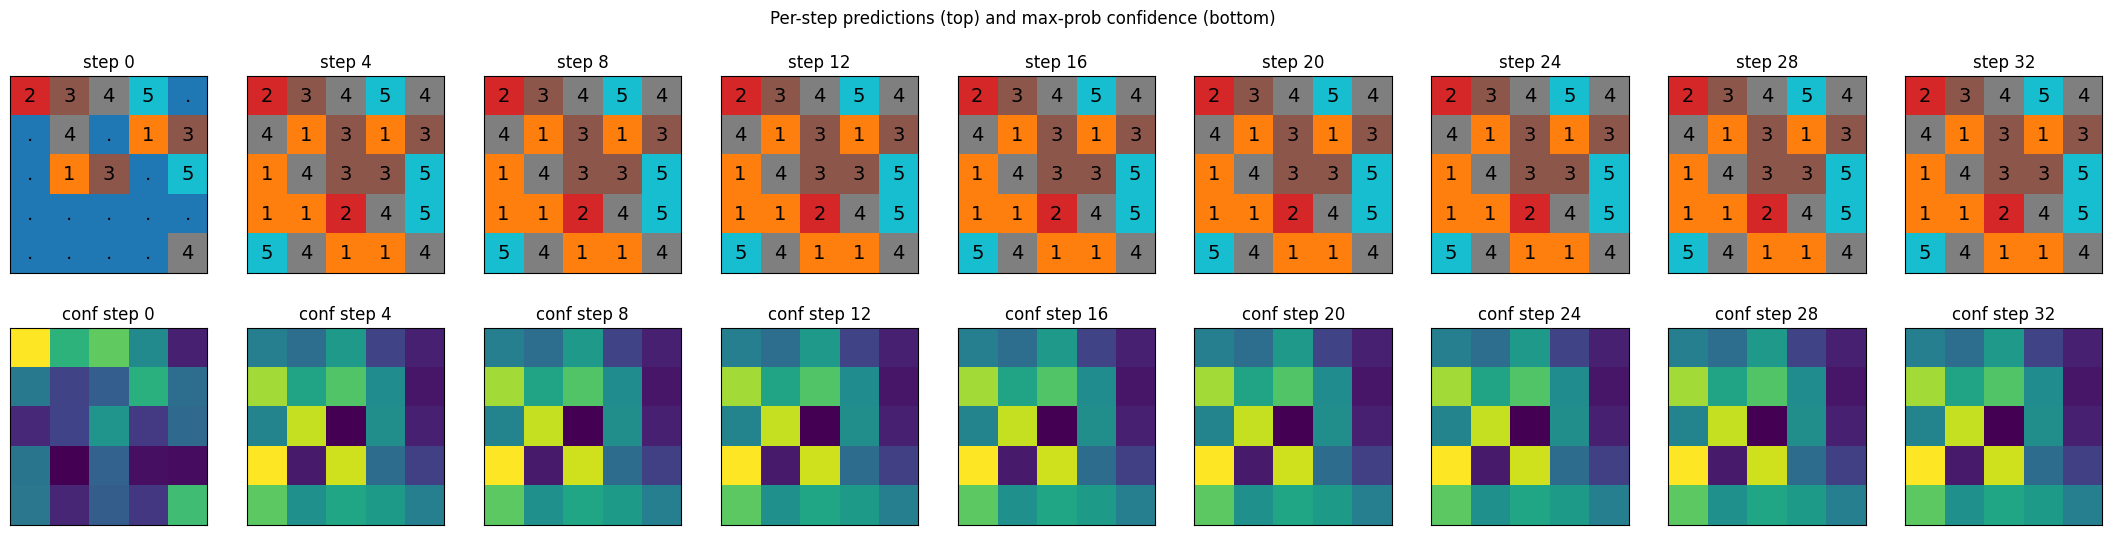

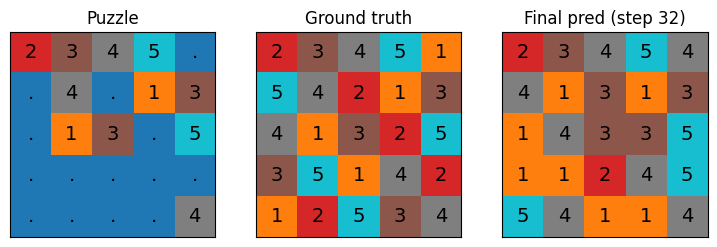

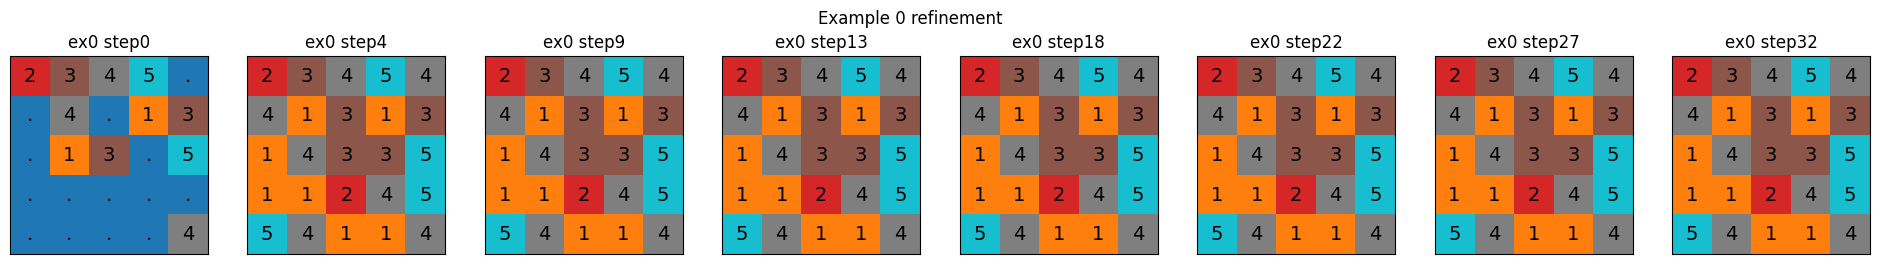

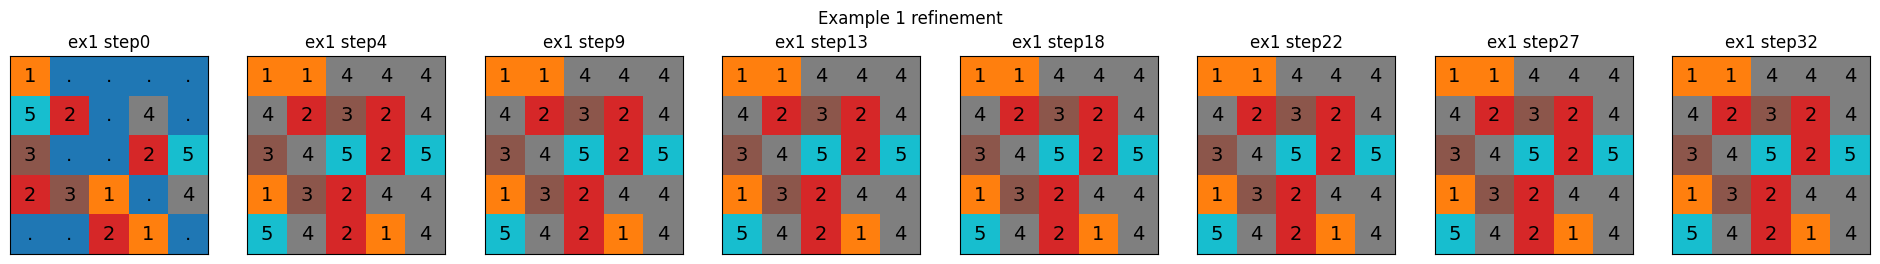

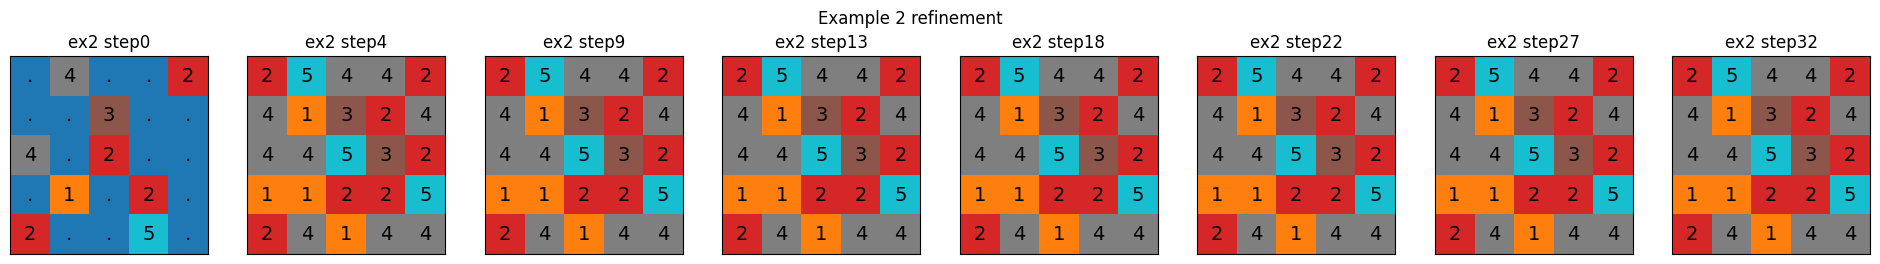

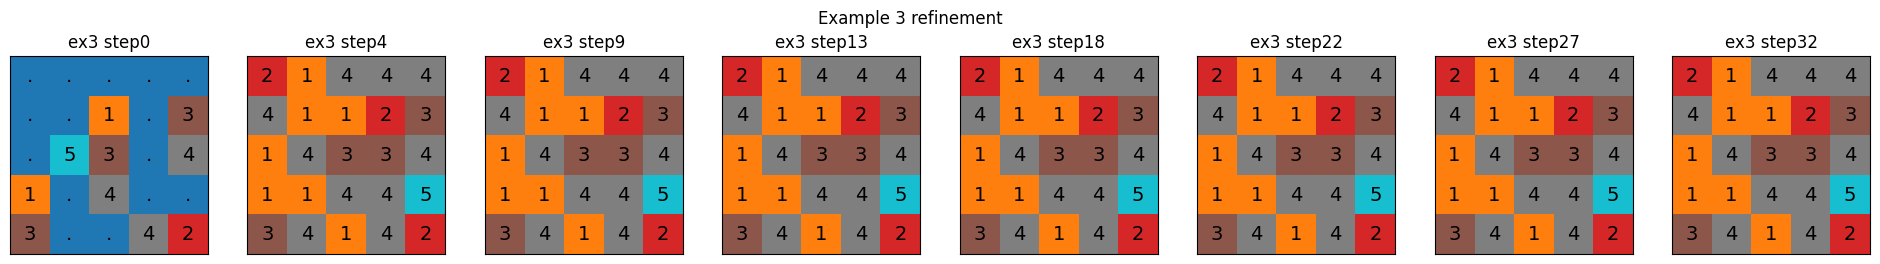

Done. You can adjust TRAIN_N, T_STEPS, ALPHA_CONSTR, D_MODEL, Z_DIM to improve performance further.


In [ ]:
# Colab-ready notebook cell: Improved TRM-MLP for 5x5 Sudoku + Visualization
# Option B (MLP core) but significantly improved:
# - structured embeddings (value + row + col)
# - separate y (current solution) and z (latent reasoning)
# - stronger constraint loss (row + col)
# - lower teacher forcing (scheduled sampling)
# - Gumbel sampling for updates
# - many recursion steps (T = 32)
# - training diagnostics & visualization of recursive refinement
#
# Paste this into a Colab cell and run.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import trange, tqdm

# -----------------------------
# Config (change these if desired)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Dataset
TRAIN_N = 20000      # increase if you have more time / GPU
TEST_N  = 3000
REMOVE_RATIO = 0.6   # fraction of cells removed to create puzzle

# Model / training
Vocab = 6            # classes 0..5 (0 empty)
D_MODEL = 160        # embedding dim per cell
Z_DIM = 96           # latent vector dim
BATCH = 256
EPOCHS = 12
T_STEPS = 32         # recursion steps (use 32 for Sudoku)
LR = 8e-4

# Loss weights
ALPHA_CE = 1.0
ALPHA_CONSTR = 12.0   # strong constraint weight (important)

# Teacher forcing schedule (start -> end)
P_TF_START = 0.40
P_TF_END = 0.05

# Misc
SEED = 1
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -----------------------------
# Utilities: generate Latin square 5x5
# -----------------------------
def generate_full_latin_5x5():
    # cyclic Latin square then randomize rows/cols/symbols
    base = [1,2,3,4,5]
    grid = []
    for i in range(5):
        row = [(j + i) % 5 + 1 for j in range(5)]
        grid.append(row)
    # randomize
    rp = list(range(5)); random.shuffle(rp)
    grid = [grid[i] for i in rp]
    cp = list(range(5)); random.shuffle(cp)
    grid = [[row[j] for j in cp] for row in grid]
    symbols = [1,2,3,4,5]; random.shuffle(symbols)
    mapping = {i+1: symbols[i] for i in range(5)}
    grid = [[mapping[val] for val in row] for row in grid]
    return np.array(grid, dtype=np.int64)

def make_puzzle_from_solution(sol, remove_ratio=REMOVE_RATIO):
    puzzle = sol.copy()
    for i in range(5):
        for j in range(5):
            if random.random() < remove_ratio:
                puzzle[i,j] = 0
    return puzzle

class Sudoku5x5Dataset(Dataset):
    def __init__(self, n_samples, remove_ratio=REMOVE_RATIO, seed=None):
        if seed is not None:
            random.seed(seed); np.random.seed(seed)
        self.puzzles = []
        self.solutions = []
        for _ in range(n_samples):
            sol = generate_full_latin_5x5()
            puz = make_puzzle_from_solution(sol, remove_ratio)
            self.puzzles.append(puz)
            self.solutions.append(sol)
    def __len__(self):
        return len(self.puzzles)
    def __getitem__(self, idx):
        puzzle = torch.from_numpy(self.puzzles[idx].reshape(-1)).long()   # (25,)
        solution = torch.from_numpy(self.solutions[idx].reshape(-1)).long() # (25,)
        return puzzle, solution

# -----------------------------
# Model: improved TRM (MLP core)
# -----------------------------
class TRM_MLP_Improved(nn.Module):
    def __init__(self, vocab_size=Vocab, d_model=D_MODEL, z_dim=Z_DIM):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.z_dim = z_dim

        # embeddings
        self.y_embed = nn.Embedding(vocab_size, d_model)   # value embedding (0..5)
        self.row_embed = nn.Embedding(5, d_model)
        self.col_embed = nn.Embedding(5, d_model)

        # latent z -> d_model
        self.z_to_d = nn.Sequential(nn.Linear(z_dim, d_model),
                                     nn.ReLU(),
                                     nn.Linear(d_model, d_model))

        # stronger per-cell MLP core (shared weights across cells)
        self.core = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.ReLU()
        )

        # heads
        self.y_logits = nn.Linear(d_model, vocab_size)   # predict distribution over 0..5
        self.z_update = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, z_dim)
        )

        # small initialization
        nn.init.normal_(self.y_embed.weight, mean=0.0, std=0.08)

    def forward(self, y_tokens, z):
        # y_tokens: (B,25), z: (B,z_dim)
        B = y_tokens.shape[0]

        # y embed
        y_e = self.y_embed(y_tokens)    # (B,25,d)
        # row/col embed (same for all batch)
        rows = torch.tensor([i//5 for i in range(25)], device=y_tokens.device).long()
        cols = torch.tensor([i%5 for i in range(25)], device=y_tokens.device).long()
        rows_e = self.row_embed(rows).unsqueeze(0).expand(B,-1,-1)  # (B,25,d)
        cols_e = self.col_embed(cols).unsqueeze(0).expand(B,-1,-1)

        z_b = self.z_to_d(z).unsqueeze(1)  # (B,1,d)
        h = y_e + rows_e + cols_e + z_b    # (B,25,d)

        # apply core per cell
        h_flat = self.core(h.view(-1, self.d_model))  # (B*25,d)
        h = h_flat.view(B,25,self.d_model)

        logits = self.y_logits(h)   # (B,25,vocab)
        z_new = self.z_update(h.mean(dim=1))  # (B,z_dim)
        return logits, z_new

# -----------------------------
# Losses & helpers
# -----------------------------
def step_cross_entropy(logits, target):
    # logits (B,25,vocab), target (B,25) values 1..5
    B = target.shape[0]
    vocab = logits.shape[-1]
    logits_flat = logits.view(B*25, vocab)
    tgt_flat = target.view(-1)  # values 1..5
    # CE across classes 0..5 with targets 1..5 is allowed
    loss = nn.functional.cross_entropy(logits_flat, tgt_flat)
    return loss

def constraint_loss_rowcol_probs(logits):
    # logits: (B,25,vocab) where vocab includes class 0..5
    # compute probs for digits 1..5
    probs = torch.softmax(logits, dim=-1)[:,:,1:]   # (B,25,5)
    B = probs.shape[0]
    probs = probs.view(B,5,5,5)  # (B, rows, cols, digits)
    # row sums over cols -> (B, rows, digits)
    row_sums = probs.sum(dim=2)
    col_sums = probs.sum(dim=1)
    row_err = ((row_sums - 1.0)**2).mean()
    col_err = ((col_sums - 1.0)**2).mean()
    return row_err + col_err

def compute_accuracy(pred_tokens, target):
    # pred_tokens & target: (B,25)
    correct = (pred_tokens == target).float()
    per_cell_acc = correct.mean().item()
    full_acc = (correct.view(correct.shape[0], -1).all(dim=1).float().mean().item())
    return per_cell_acc, full_acc

# Gumbel sampling helper (differentiable-ish via straight-through)
def gumbel_sample(logits, tau=0.5, hard=True):
    # logits: (B,25,vocab)
    shape = logits.shape
    U = torch.rand(shape, device=logits.device)
    g = -torch.log(-torch.log(U + 1e-9) + 1e-9)
    y = (logits + g) / tau
    probs = torch.softmax(y, dim=-1)
    if hard:
        # straight-through: return one-hot hard sample with gradient from probs
        argmax = probs.argmax(dim=-1)
        one_hot = torch.zeros_like(probs).scatter_(-1, argmax.unsqueeze(-1), 1.0)
        ret = one_hot - probs.detach() + probs
        sampled = argmax
        return ret, sampled
    else:
        return probs, probs.argmax(dim=-1)

# -----------------------------
# Prepare data loaders
# -----------------------------
train_ds = Sudoku5x5Dataset(TRAIN_N, remove_ratio=REMOVE_RATIO, seed=SEED)
test_ds  = Sudoku5x5Dataset(TEST_N, remove_ratio=REMOVE_RATIO+0.02, seed=SEED+1)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

# -----------------------------
# Instantiate model + optimizer
# -----------------------------
model = TRM_MLP_Improved(vocab_size=Vocab, d_model=D_MODEL, z_dim=Z_DIM).to(device)
opt = optim.Adam(model.parameters(), lr=LR)
print("Model params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# -----------------------------
# Training + evaluation loops
# -----------------------------
def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    total_ce = 0.0
    total_constr = 0.0
    total_cell_acc = 0.0
    total_full_acc = 0.0
    steps = 0

    # linear teacher forcing schedule
    p_tf = P_TF_START + (P_TF_END - P_TF_START) * (epoch / max(1, EPOCHS-1))

    for puzzles, sols in train_loader:
        puzzles = puzzles.to(device)    # (B,25) 0..5
        sols = sols.to(device)          # (B,25) 1..5
        B = puzzles.size(0)

        y = puzzles.clone()  # start with puzzle givens
        z = torch.zeros((B, Z_DIM), device=device)

        loss_sum = 0.0
        ce_sum = 0.0
        constr_sum = 0.0

        for t in range(T_STEPS):
            logits, z = model(y, z)   # logits (B,25,vocab)
            ce = step_cross_entropy(logits, sols)
            constr = constraint_loss_rowcol_probs(logits)

            loss = ALPHA_CE * ce + ALPHA_CONSTR * constr
            loss_sum = loss_sum + loss
            ce_sum += ce.item()
            constr_sum += constr.item()

            # scheduled sampling: teacher forcing with prob p_tf
            if random.random() < p_tf:
                # teacher forcing: set y to ground truth (0..5) — but zeros not used in target; safe since target in 1..5
                y = sols.clone()
            else:
                # sample via Gumbel straight-through
                _, sampled = gumbel_sample(logits, tau=0.5, hard=True)
                y = sampled.detach().clone()

        # backprop
        opt.zero_grad()
        (loss_sum / T_STEPS).backward()
        opt.step()

        # metrics on final logits
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            per_cell_acc, full_acc = compute_accuracy(preds, sols)
        total_cell_acc += per_cell_acc
        total_full_acc += full_acc

        total_loss += (loss_sum.item() / T_STEPS)
        total_ce += (ce_sum / T_STEPS)
        total_constr += (constr_sum / T_STEPS)
        steps += 1

    return {
        'loss': total_loss / steps,
        'ce': total_ce / steps,
        'constr': total_constr / steps,
        'cell_acc': total_cell_acc / steps,
        'full_acc': total_full_acc / steps,
        'p_tf': p_tf
    }

def evaluate():
    model.eval()
    total_cell_acc = 0.0
    total_full_acc = 0.0
    steps = 0
    with torch.no_grad():
        for puzzles, sols in test_loader:
            puzzles = puzzles.to(device); sols = sols.to(device)
            B = puzzles.size(0)
            y = puzzles.clone()
            z = torch.zeros((B, Z_DIM), device=device)
            for t in range(T_STEPS):
                logits, z = model(y, z)
                y = logits.argmax(dim=-1)
            preds = y
            per_cell_acc, full_acc = compute_accuracy(preds, sols)
            total_cell_acc += per_cell_acc
            total_full_acc += full_acc
            steps += 1
    return {'cell_acc': total_cell_acc/steps, 'full_acc': total_full_acc/steps}

# -----------------------------
# Training run with diagnostics
# -----------------------------
train_stats = []
val_stats = []

print("Starting training...")
for ep in range(EPOCHS):
    stats = train_one_epoch(ep)
    val = evaluate()
    train_stats.append(stats)
    val_stats.append(val)
    print(f"Epoch {ep+1}/{EPOCHS} | loss {stats['loss']:.4f} | ce {stats['ce']:.4f} | constr {stats['constr']:.4f} | "
          f"train_cell {stats['cell_acc']:.4f} train_full {stats['full_acc']:.4f} | val_cell {val['cell_acc']:.4f} val_full {val['full_acc']:.4f} | p_tf {stats['p_tf']:.3f}")

# -----------------------------
# Plot training diagnostics
# -----------------------------
epochs_range = list(range(1, EPOCHS+1))
losses = [s['loss'] for s in train_stats]
ces = [s['ce'] for s in train_stats]
constrs = [s['constr'] for s in train_stats]
train_cell = [s['cell_acc'] for s in train_stats]
train_full = [s['full_acc'] for s in train_stats]
val_cell = [s['cell_acc'] for s in val_stats]
val_full = [s['full_acc'] for s in val_stats]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(epochs_range, losses, '-o'); plt.title("Train loss"); plt.xlabel("epoch")
plt.subplot(1,3,2)
plt.plot(epochs_range, ces, '-o', label='CE'); plt.plot(epochs_range, constrs, '-o', label='constr')
plt.legend(); plt.title("Loss components")
plt.subplot(1,3,3)
plt.plot(epochs_range, train_cell, '-o', label='train_cell'); plt.plot(epochs_range, val_cell, '-o', label='val_cell')
plt.plot(epochs_range, train_full, '-o', label='train_full'); plt.plot(epochs_range, val_full, '-o', label='val_full')
plt.legend(); plt.title("Accuracy")
plt.show()

# -----------------------------
# Visualization helper: display grid of 5x5 with colors
# -----------------------------
cmap = plt.get_cmap('tab10')
norm = colors.BoundaryNorm(list(range(7)), cmap.N)

def plot_grid(grid25, title=None, ax=None):
    # grid25: shape (5,5) numeric (0..5)
    mat = np.array(grid25).reshape(5,5)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(mat, cmap=cmap, norm=norm)
    for i in range(5):
        for j in range(5):
            val = int(mat[i,j])
            txt = "." if val==0 else str(val)
            ax.text(j, i, txt, ha="center", va="center", color='k', fontsize=14)
    ax.set_xticks([]); ax.set_yticks([])
    if title: ax.set_title(title)

# -----------------------------
# Visualize recursive refinement on some test examples
# -----------------------------
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader))
    puzzles, sols = sample_batch
    puzzles = puzzles.to(device); sols = sols.to(device)
    B = puzzles.size(0)
    # pick first example in batch
    idx = 0
    y = puzzles.clone()
    z = torch.zeros((B, Z_DIM), device=device)
    trace = []
    trace_probs = []
    trace.append(y[idx].cpu().numpy())
    for t in range(T_STEPS):
        logits, z = model(y, z)
        probs = torch.softmax(logits, dim=-1)
        y = logits.argmax(dim=-1)  # greedy
        trace.append(y[idx].cpu().numpy())
        trace_probs.append(probs[idx].cpu().numpy())
    # plot initial, ground truth, and per-step snapshots (sample every few steps)
    n_steps_to_show = 9
    step_idxs = np.linspace(0, T_STEPS, n_steps_to_show, dtype=int)
    fig, axs = plt.subplots(2, n_steps_to_show, figsize=(3*n_steps_to_show,6))
    # top row: per-step predictions
    for col, s in enumerate(step_idxs):
        grid = trace[s]
        title = f"step {s}"
        plot_grid(grid, title=title, ax=axs[0,col])
    # bottom row: show soft-prob / entropy by argmax digit confidence (optional)
    final_logits, _ = model(puzzles.to(device), torch.zeros((B,Z_DIM), device=device))  # just compute final logits as example
    for col, s in enumerate(step_idxs):
        if s==0:
            probs_map = np.max(torch.softmax(final_logits, dim=-1).cpu().numpy()[idx], axis=-1) # fallback
        else:
            probs_map = np.max(trace_probs[min(s-1, len(trace_probs)-1)], axis=-1)  # (25,6)-> (25,)
        # reshape and plot confidence heatmap
        mat = probs_map.reshape(5,5)
        ax = axs[1,col]
        im = ax.imshow(mat, cmap='viridis') # Removed vmin and vmax
        ax.set_title("conf step "+str(s))
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle("Per-step predictions (top) and max-prob confidence (bottom)")
    plt.show()

    # show initial puzzle / GT / final
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    plot_grid(puzzles[idx].cpu().numpy(), title="Puzzle", ax=axs[0])
    plot_grid(sols[idx].cpu().numpy(), title="Ground truth", ax=axs[1])
    plot_grid(trace[-1], title=f"Final pred (step {T_STEPS})", ax=axs[2])
    plt.show()

# -----------------------------
# Example: print mosaic of several test examples with their traces
# -----------------------------
num_examples = 4
examples = list(range(num_examples))
sample_batch = next(iter(test_loader))
puzzles, sols = sample_batch
puzzles = puzzles.to(device); sols = sols.to(device)
B = puzzles.size(0)
y = puzzles.clone()
z = torch.zeros((B, Z_DIM), device=device)

traces = [[] for _ in range(num_examples)]
# Initialize all traces with their respective puzzles
for i_ex in range(num_examples):
    traces[i_ex].append(puzzles[examples[i_ex]].cpu().numpy())

for t in range(T_STEPS):
    logits, z = model(y, z)
    y = logits.argmax(dim=-1)
    for i,ex in enumerate(examples):
        traces[i].append(y[ex].cpu().numpy())

# plot step progression for these examples (few columns)
cols = 8
for i,ex in enumerate(examples):
    fig, axs = plt.subplots(1, cols, figsize=(3*cols,3))
    step_which = np.linspace(0, T_STEPS, cols, dtype=int)
    for c, s in enumerate(step_which):
        plot_grid(traces[i][s], title=f"ex{i} step{s}", ax=axs[c])
    plt.suptitle(f"Example {i} refinement")
    plt.show()

print("Done. You can adjust TRAIN_N, T_STEPS, ALPHA_CONSTR, D_MODEL, Z_DIM to improve performance further.")